In [1]:
import json
from datetime import datetime
import random
from dataclasses import dataclass, asdict
import os
import shutil
import numpy as np
import cv2
from observer import CalibratedObserver, CameraChange, TrackedObject, MiniMapObject, HexCaptureConfiguration, Transition, distanceFormula

In [2]:
MM_TO_INCHES =  0.03937008
INCHES_TO_MM = 25.4

In [3]:
def numpy_serializer(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")
    
def numpyizeDeserializedCameraChange(deserializedCameraChange: dict):
    if deserializedCameraChange['camName'] is not None:
        deserializedCameraChange['changeContours'] = [np.array(contour, dtype=np.int32) for contour in deserializedCameraChange['changeContours']]
        deserializedCameraChange['after'] = np.array(deserializedCameraChange['after'], dtype=np.int32)
        deserializedCameraChange['before'] = np.array(deserializedCameraChange['before'], dtype=np.int32)
        deserializedCameraChange['lastChange'] = numpyizeDeserializedCameraChange(deserializedCameraChange['lastChange'])
    return CameraChange(**deserializedCameraChange)

In [4]:
@dataclass()
class HarmonyMachine(CalibratedObserver):
    cc: HexCaptureConfiguration

    def __post_init__(self):
        self.reset()

    def reset(self, database_file=None):
        CalibratedObserver.reset(self)

    def __repr__(self):
        return f"HarmonyMachine -- Cycle: {self.cycleCounter:5} -- Objects: {len(self.memory):5} -- {self.mode}|{self.state}"
    
    def cycleStatus(self):
        return f"{self}"

    def objectLocation(self, harmonyObject) -> tuple[float, float, float]:
        return self.captureRealCoord(harmonyObject)

    def objectLastDistance(self, harmonyObject: TrackedObject):
        #TODO: implement
        return self.captureRealCoord(harmonyObject)
        
    def saveGame(self, gameName="harmony"):
        pass
        #TODO: Implement
        
    def loadGame(self, gameName="harmony"):
        self.reset()
        # TODO: Implement
    
    def getCameraImagesWithChanges(self, cameraKeys=None, show_interactions=True):
        if cameraKeys is None:
            cameraKeys = self.cc.cameras.keys()

        images = {}
        for camName in cameraKeys:
            cam = self.cc.cameras[camName]
            camImage = cam.cropToActiveZone(cam.mostRecentFrame.copy())
            
            # Paint known objects faction color
            for objAndColor in self.objectsAndColors[::-1]:
                memObj = objAndColor.object
                color = objAndColor.color
                if memObj.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([memObj.changeSet[camName].changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, memContour, -1, color, -1)
                    if show_interactions and self.objectCouldInteract(memObj):
                        center_x = int(np.mean(memContour[:, :, 0]))  # Mean of x-coordinates
                        center_y = int(np.mean(memContour[:, :, 1]))  # Mean of y-coordinates
                        camImage = cv2.circle(camImage, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)

                if memObj.expectedChange is not None and memObj.expectedChange.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([memObj.expectedChange.changeSet[camName].changePoints], dtype=np.int32)
                    center_x = int(np.mean(memContour[:, :, 0]))  # Mean of x-coordinates
                    center_y = int(np.mean(memContour[:, :, 1]))  # Mean of y-coordinates

                    objContour = np.array([memObj.expectedChange.lastChange.changeSet[camName].changePoints], dtype=np.int32)
                    obj_center_x = int(np.mean(objContour[:, :, 0]))  # Mean of x-coordinates
                    obj_center_y = int(np.mean(objContour[:, :, 1]))  # Mean of y-coordinates
                    camImage = cv2.circle(camImage, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)
                    camImage = cv2.line(
                        camImage,
                        np.array((center_x, center_y), dtype=np.int32),
                        np.array((obj_center_x, obj_center_y), dtype=np.int32),
                        (125, 255, 0), 5)

            # Paint last changes red
            if self.lastChanges is not None and not self.lastChanges.empty:
                lastChange = self.lastChanges.changeSet[camName]
                if lastChange is not None and lastChange.changeType not in ['delete', None]:
                    lastChangeContour = np.array([lastChange.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastChangeContour, -1 , (0, 0, 127), -1)

            # Paint classification green
            if self.lastClassification is not None and not self.lastClassification.empty:
                lastClass = self.lastClassification.changeSet[camName]
                if lastClass is not None and lastClass.changeType not in ['delete', None]:
                    lastClassContour = np.array([lastClass.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastClassContour, -1 , (0, 255, 0), -1)

            camImage = cv2.resize(camImage, [480, 640], interpolation=cv2.INTER_AREA)
            images[camName] = camImage
        return images       

Starting Cycle HarmonyMachine -- Cycle:     0 -- Objects:     0 -- passive|idle


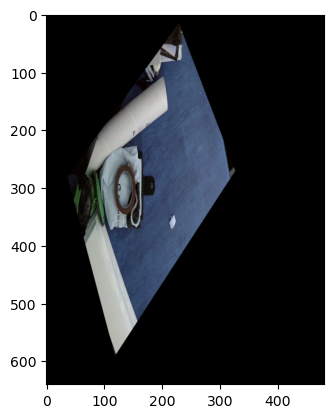

In [5]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = HexCaptureConfiguration()
    hm = HarmonyMachine(cc=cc)
    hm.cycle()
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

In [9]:
if __name__ == "__main__":
    for i in range(3):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()